In [1]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.crs import CRS
import numpy as np

In [2]:
df = gpd.read_file('chips.geojson')
df.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-159.648125,69.21,3,3_38,2011-07-17,1,99,"POLYGON ((-159.89875 69.30000, -159.65900 69.3..."
1,-112.983750,67.05,4,4_27,2012-07-23,1,114,"POLYGON ((-113.21200 67.14000, -113.09850 67.1..."
2,17.698500,65.97,4,4_43,2010-07-24,1,20,"POLYGON ((17.61000 66.06000, 17.91700 66.06000..."
3,59.675000,65.79,3,3_1,2011-07-13,1,112,"POLYGON ((59.86900 65.88000, 59.89200 65.88000..."
4,-96.604375,62.73,4,4_34,2012-08-27,1,115,"POLYGON ((-96.79875 62.82000, -96.57700 62.820..."


In [3]:
chip_id = 42
bounds_4326 = df[df.random_id == chip_id].total_bounds
bounds_4326

array([-95.97375,  32.94   , -95.76   ,  33.12   ])

In [4]:
bounds_3857 = rasterio.warp.transform_bounds(CRS.from_epsg(4326),
                                             CRS.from_epsg(3857),
                                             *bounds_4326)
bounds_3857

(-10683748.979520984,
 3887342.672226422,
 -10659954.438363912,
 3911242.8098018253)

Show available providers (can use independent url too)

In [5]:
# ctx.providers

Getting a high zoom level!

In [6]:
zoom_level=16
out_path = f'tiles_c{chip_id}_z{zoom_level}.tif'
X, extent = ctx.bounds2raster(*bounds_3857, 
                              out_path, 
                              zoom=zoom_level,
                              source=ctx.providers.CartoDB.PositronNoLabels)
X.shape

(10240, 10240, 4)

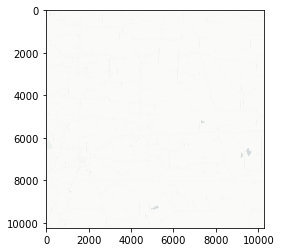

In [7]:
plt.imshow(X)

# Create Water Mask

In [8]:
with rasterio.open(out_path) as ds:
    rgb = ds.read().transpose([1, 2, 0])[..., :3]
    profile = ds.profile

In [9]:
def obtain_mask_from_color(arr: np.ndarray, 
                           rgb_fixed:list, 
                           tol=1):
    """
    Looking at the first 3 channels of our image, we look at +/- 
    tolerance within some fixed 3 channel value (given by rgb_fixed)
    """
    assert(arr.shape[2] == 3)
    X = arr.astype(float)
    mask_r = np.abs(X[..., 0] - rgb_fixed[0]) < tol
    mask_g = np.abs(X[..., 1] - rgb_fixed[1]) < tol
    mask_b = np.abs(X[..., 2] - rgb_fixed[2]) < tol
    return mask_r & mask_g & mask_b

In [10]:
water_color = [212, 218, 220]
water_mask = obtain_mask_from_color(rgb, water_color)

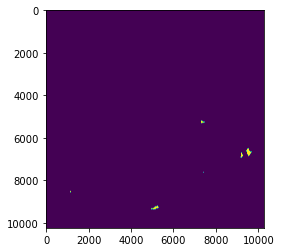

In [11]:
plt.imshow(water_mask)

In [12]:
p = profile.copy()
p['count'] = 1
with rasterio.open(f'water_mask_cartodb_{chip_id}.tif', 'w', **p) as ds:
    ds.write(water_mask.astype(int), 1)